In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pylab
import scipy.stats as stats
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, average_precision_score, f1_score, auc, precision_recall_curve, recall_score, precision_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install scikit_fuzzy
import skfuzzy as fuzz
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout
!pip install pdpbox
from sklearn.inspection import PartialDependenceDisplay

In [3]:
data = pd.read_csv('BO_Training_Dataset.csv')
data.drop(['sku'], axis = 1,inplace=True)

In [4]:
cat = data.select_dtypes(include = ['object']).columns
for col in cat:
    data[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    data[col] = data[col].astype(int)

In [5]:
data.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)
data.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [6]:
skewed_right = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month',
                'forecast_9_month' , 'sales_1_month','sales_3_month',
                'sales_6_month','sales_9_month' ,
                'min_bank','pieces_past_due','local_bo_qty']

In [7]:
data_y = data['went_on_backorder']
X_train, X_test, y_train, y_test = train_test_split(data.drop(['went_on_backorder'], axis=1), data_y , random_state = 42 , stratify=data_y,test_size=0.20)

In [8]:
log_columns = []

for i in skewed_right:
    log_columns.append(X_train.columns.get_loc(i))

In [9]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)
Xtrain = imp.transform(X_train)
Xtest = imp.transform(X_test)

In [10]:
def log_transform(a):
    sign = np.sign(a[log_columns])
    a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign
    return a

In [11]:
log_columns

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]

In [12]:
X_train_log = np.apply_along_axis(log_transform, 1, Xtrain)
X_test_log = np.apply_along_axis(log_transform, 1, Xtest)

In [13]:
sc = RobustScaler().fit(X_train_log)
X_train_log = sc.transform(X_train_log)
X_test_log = sc.transform(X_test_log)

## **Dummy**

In [14]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_log, y_train)

DummyClassifier(strategy='uniform')

## **BRFC**

In [15]:
bb = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(X_train_log, y_train)

## **Fuzzy+BRFC**

In [16]:
fuzzy_params = {
    'national_inv': [0, 10, 100],
    'lead_time': [0, 2, 10],
    'in_transit_qty': [0, 5, 100],
    'forecast_3_month': [0, 10, 100],
    'forecast_6_month': [0, 10, 100],
    'forecast_9_month': [0, 10, 100],
    'sales_1_month': [0, 10, 100],
    'sales_3_month': [0, 10, 100],
    'sales_6_month': [0, 10, 100],
    'sales_9_month': [0, 10, 100],
    'min_bank': [0, 10, 100],
    'potential_issue': [0, 0.5, 1],
    'pieces_past_due': [0, 5, 50],
    'perf_6_month_avg': [0, 0.5, 1],
    'perf_12_month_avg': [0, 0.5, 1],
    'local_bo_qty': [0, 5, 50],
    'deck_risk': [0, 0.5, 1],
    'oe_constraint': [0, 0.5, 1],
    'ppap_risk': [0, 0.5, 1],
    'stop_auto_buy': [0, 0.5, 1],
    'rev_stop': [0, 0.5, 1]
}

def apply_fuzzy_logic(data, fuzzy_params):
    fuzzy_inputs = []
    for i, (column, params) in enumerate(fuzzy_params.items()):
        fuzzy_membership = fuzz.trimf(data[:, i], params)
        fuzzy_inputs.append(fuzzy_membership)
    fuzzy_inputs_2D = [fuzzy_membership.reshape(-1, 1) for fuzzy_membership in fuzzy_inputs]
    return np.concatenate(fuzzy_inputs_2D, axis=1)

X_train_fuzzy = apply_fuzzy_logic(X_train_log, fuzzy_params)

bb_fuzzy = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(X_train_fuzzy, y_train)

## **VAE + BRFC**

In [17]:
input_dim = X_train_log.shape[1]
latent_dim = 13

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

vae = Model(input_layer, decoded)

vae.compile(optimizer='adam', loss='mse')

vae.fit(X_train_log, X_train_log, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

encoder = Model(input_layer, encoded)
encoded_X_train = encoder.predict(X_train_log)

combined_X_train = np.concatenate([X_train_log, encoded_X_train], axis=1)

bb_autoencoder = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(combined_X_train, y_train)

Epoch 1/10
20972/20972 [==============================] - 61s 3ms/step - loss: 0.0088 - val_loss: 0.0019
Epoch 2/10
20972/20972 [==============================] - 56s 3ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 3/10
20972/20972 [==============================] - 59s 3ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 4/10
20972/20972 [==============================] - 53s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/10
20972/20972 [==============================] - 54s 3ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/10
20972/20972 [==============================] - 52s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/10
20972/20972 [==============================] - 55s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 8/10
20972/20972 [==============================] - 56s 3ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/10
20972/20972 [==============================] - 60s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10
26215/26215 [==============================

In [18]:
encoded_X_test = encoder.predict(X_test_log)
combined_X_test = np.concatenate([X_test_log, encoded_X_test], axis=1)

6554/6554 [==============================] - 10s 2ms/step


## **MLP**

In [19]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

mlp_model.fit(X_train_log, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20972/20972 [==============================] - 66s 3ms/step - loss: 0.0347 - accuracy: 0.9915 - val_loss: 0.0335 - val_accuracy: 0.9914
Epoch 2/10
20972/20972 [==============================] - 67s 3ms/step - loss: 0.0328 - accuracy: 0.9915 - val_loss: 0.0327 - val_accuracy: 0.9914
Epoch 3/10
20972/20972 [==============================] - 66s 3ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.0332 - val_accuracy: 0.9913
Epoch 4/10
20972/20972 [==============================] - 77s 4ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.0325 - val_accuracy: 0.9913
Epoch 5/10
20972/20972 [==============================] - 92s 4ms/step - loss: 0.0322 - accuracy: 0.9915 - val_loss: 0.0327 - val_accuracy: 0.9913
Epoch 6/10
20972/20972 [==============================] - 70s 3ms/step - loss: 0.0320 - accuracy: 0.9915 - val_loss: 0.0325 - val_accuracy: 0.9913
Epoch 7/10
20972/20972 [==============================] - 85s 4ms/step - loss: 0.0320 - accuracy: 0.9915 - val_loss: 0

In [20]:
from sklearn.metrics import roc_curve

dummy_preds_proba = dummy_clf.predict_proba(X_test_log)[:, 1]
bb_preds_proba = bb.predict_proba(X_test_log)[:, 1]
bb_fuzzy_preds_proba = bb_fuzzy.predict_proba(X_test_log)[:, 1]
bb_autoencoder_preds_proba = bb_autoencoder.predict_proba(combined_X_test)[:, 1]
mlp_preds_proba = mlp_model.predict(X_test_log)

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_preds_proba)
fpr_bb, tpr_bb, _ = roc_curve(y_test, bb_preds_proba)
fpr_bb_fuzzy, tpr_bb_fuzzy, _ = roc_curve(y_test, bb_fuzzy_preds_proba)
fpr_bb_autoencoder, tpr_bb_autoencoder, _ = roc_curve(y_test, bb_autoencoder_preds_proba)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_preds_proba)

auc_dummy = auc(fpr_dummy, tpr_dummy)
auc_bb = auc(fpr_bb, tpr_bb)
auc_bb_fuzzy = auc(fpr_bb_fuzzy, tpr_bb_fuzzy)
auc_bb_autoencoder = auc(fpr_bb_autoencoder, tpr_bb_autoencoder)
auc_mlp = auc(fpr_mlp, tpr_mlp)

6554/6554 [==============================] - 11s 2ms/step


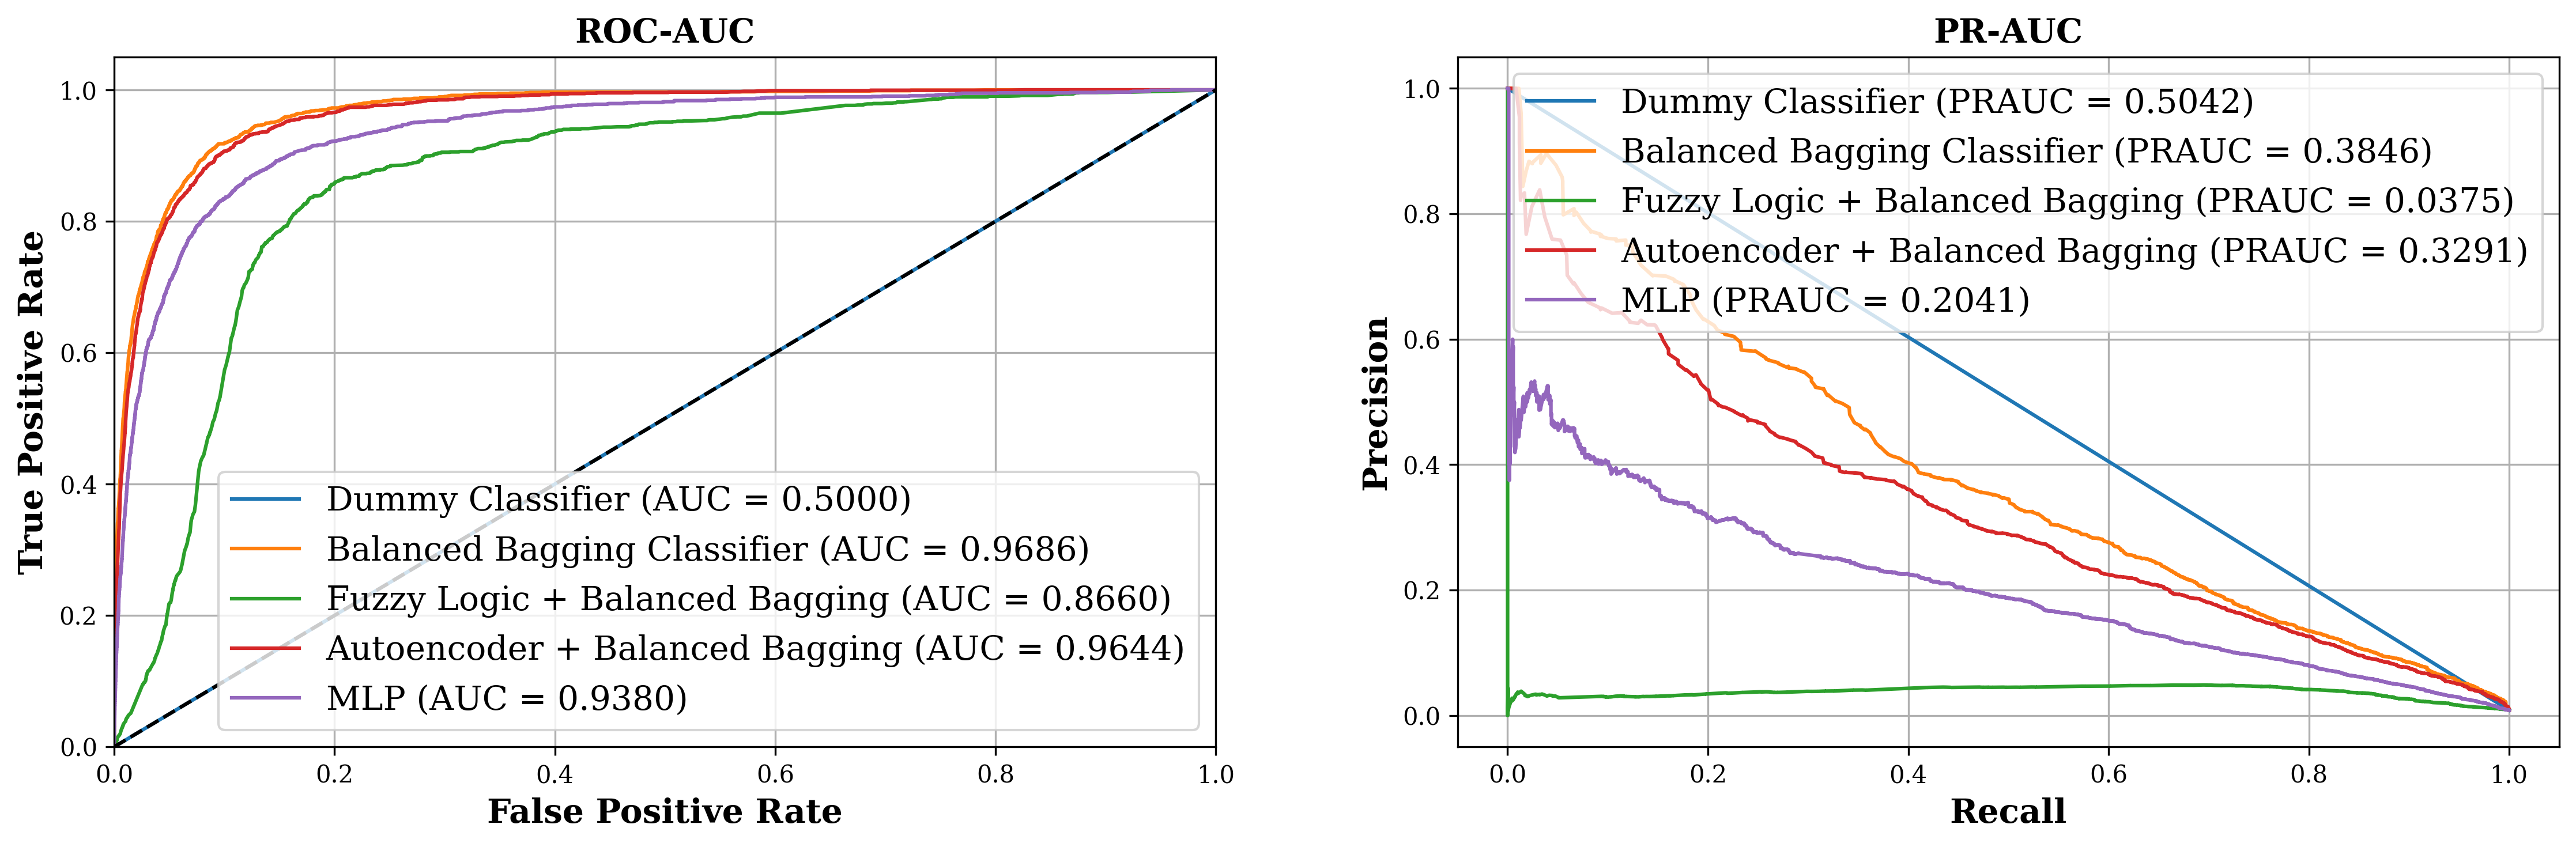

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].plot(fpr_dummy, tpr_dummy, label=f'Dummy Classifier (AUC = {auc_dummy:.4f})')
axes[0].plot(fpr_bb, tpr_bb, label=f'Balanced Bagging Classifier (AUC = {auc_bb:.4f})')
axes[0].plot(fpr_bb_fuzzy, tpr_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (AUC = {auc_bb_fuzzy:.4f})')
axes[0].plot(fpr_bb_autoencoder, tpr_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (AUC = {auc_bb_autoencoder:.4f})')
axes[0].plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=14)
axes[0].set_title('ROC-AUC', fontsize=14, fontweight='bold')
axes[0].grid()

preauc_dummy, recall_dummy, _ = precision_recall_curve(y_test, dummy_preds_proba)
auc_dummy = auc(recall_dummy, preauc_dummy)
preauc_bb, recall_bb, _ = precision_recall_curve(y_test, bb_preds_proba)
auc_bb = auc(recall_bb, preauc_bb)
preauc_bb_fuzzy, recall_bb_fuzzy, _ = precision_recall_curve(y_test, bb_fuzzy_preds_proba)
auc_fuzzy = auc(recall_bb_fuzzy, preauc_bb_fuzzy)
preauc_bb_autoencoder, recall_bb_autoencoder, _ = precision_recall_curve(y_test, bb_autoencoder_preds_proba)
auc_bbauto = auc(recall_bb_autoencoder, preauc_bb_autoencoder)
preauc_mlp, recall_mlp, _ = precision_recall_curve(y_test, mlp_preds_proba)
auc_mlp = auc(recall_mlp, preauc_mlp)

axes[1].plot(recall_dummy, preauc_dummy, label=f'Dummy Classifier (PRAUC = {auc_dummy:.4f})')
axes[1].plot(recall_bb, preauc_bb, label=f'Balanced Bagging Classifier (PRAUC = {auc_bb:.4f})')
axes[1].plot(recall_bb_fuzzy, preauc_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (PRAUC = {auc_fuzzy:.4f})')
axes[1].plot(recall_bb_autoencoder, preauc_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (PRAUC = {auc_bbauto:.4f})')
axes[1].plot(recall_mlp, preauc_mlp, label=f'MLP (PRAUC = {auc_mlp:.4f})')
axes[1].set_xlabel('Recall', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=14)
axes[1].set_title('PR-AUC', fontsize=14, fontweight='bold')
axes[1].grid()

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix

y_pred = bb.predict(X_test_log)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

from sklearn.metrics import f1_score
# Calculate macro-average F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro-average F1 Score:", macro_f1)

f2_score = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2_score)

from sklearn.metrics import matthews_corrcoef
mcc_score = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc_score)

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test, y_pred)
print("Cohen’s Kappa:", kappa_score)

from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_score)

Confusion Matrix:
[[184101  23834]
 [   121   1659]]
F1 Score: 0.12165878341216586
Macro-average F1 Score: 0.5302867773959979
F2 Score: 0.2543464262717321
Matthews Correlation Coefficient (MCC): 0.2294707177261081
Cohen’s Kappa: 0.10749699094724707
Brier Score: 0.11422645018239039


In [23]:
total_samples = len(y_test)  # Total number of samples

# Calculate percentages for each cell in the confusion matrix
conf_matrix_percent = conf_matrix / total_samples * 100
# Set printing options to display as real numbers with two decimal places
np.set_printoptions(formatter={'float': lambda x: "{:.2f}".format(x)})
# Print the confusion matrix with percentages
print("Confusion Matrix (%):")
print(conf_matrix_percent.round(2))

Confusion Matrix (%):
[[87.79 11.36]
 [0.06 0.79]]


In [118]:
# Define misclassification costs
false_negative_cost = 100  # Cost of misclassifying a backorder item as non-backorder
false_positive_cost = 10   # Cost of misclassifying a non-backorder item as backorder

misclassification_cost = (conf_matrix[1, 0] * false_negative_cost) + (conf_matrix[0, 1] * false_positive_cost)

print("Misclassification Cost:", misclassification_cost)

Misclassification Cost: 192430


In [111]:
def calculate_profit(row, costs, revenue):
    inventory_level = row['national_inv'] + row['in_transit_qty']
    backorders = row['went_on_backorder']
    lead_time = row['lead_time']
    potential_issue = row['potential_issue']
    deck_risk = row['deck_risk']

    holding_cost = costs['holding']
    backorder_cost = costs['backorder']
    lead_time_cost = costs['lead_time']
    potential_issue_cost = costs['potential_issue']
    deck_risk_cost = costs['deck_risk']

    if backorders == 0:
        profit = revenue - (holding_cost * inventory_level) - (lead_time_cost * lead_time) - (potential_issue_cost * potential_issue) - (deck_risk_cost * deck_risk)
    else:
        profit = revenue - (holding_cost * inventory_level) - (backorder_cost * backorders) - (lead_time_cost * lead_time) - (potential_issue_cost * potential_issue) - (deck_risk_cost * deck_risk)
    return profit

df_predictions = pd.DataFrame(y_pred, columns=['went_on_backorder'])

df_X_test = pd.DataFrame(X_test_log, columns=['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
                                              'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month',
                                              'sales_6_month', 'sales_9_month', 'min_bank', 'potential_issue',
                                              'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty',
                                              'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'])

df_combined = pd.concat([df_X_test, df_predictions], axis=1)

costs = {
    'holding': 2,
    'backorder': 50,
    'lead_time': 20,
    'potential_issue': 10,
    'deck_risk': 0.5
}

df_combined['revenue'] = (df_combined['sales_1_month'] + df_combined['sales_3_month'] + df_combined['sales_6_month'] + df_combined['sales_9_month']).sum()
df_combined['profit'] = df_combined.apply(lambda row: calculate_profit(row, costs, row['revenue']), axis=1)

print(df_combined['profit'].mean())


2793.3497353152065
